In [1]:
# ==============================================================================
#  Шаг 1: Настройка окружения и установка библиотек
# ==============================================================================
print("⏳ Установка необходимых библиотек...")
!pip install moviepy opencv-python-headless pandas openpyxl transformers torch -q
!pip install git+https://github.com/openai/whisper.git -q
!pip install huggingface_hub -q
print("✅ Установка завершена.")

⏳ Установка необходимых библиотек...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ Установка завершена.


In [ ]:
import os
import json
import pandas as pd
import cv2
from moviepy.editor import VideoFileClip
import whisper
import torch
from IPython.display import display, Image, Video, HTML
from google.colab import drive
from huggingface_hub import notebook_login, create_repo, upload_folder

# Монтируем Google Drive для доступа к файлам
print("🔑 Монтирование Google Drive...")
drive.mount('/content/drive')
print("✅ Google Drive смонтирован.")

# Проверяем наличие GPU (Whisper будет работать значительно быстрее)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Выбрано устройство для вычислений: {DEVICE}")

In [3]:
# ==============================================================================
#  Шаг 2: Определение путей и загрузка данных
# ==============================================================================
# Укажите путь к вашим файлам на Google Drive
DRIVE_PATH = '/content/drive/MyDrive/PPI_Project/in' # <-- ИЗМЕНИТЕ НА ВАШ ПУТЬ

# Входные файлы
VIDEO_INPUT_PATH = os.path.join(DRIVE_PATH, '03.mp4')
JSON_INPUT_PATH = os.path.join(DRIVE_PATH, '03.json')
PATTERNS_XLSX_PATH = os.path.join(DRIVE_PATH, 'patterns.xlsx')

# Выходная директория для датасета
DATASET_OUTPUT_DIR = '/content/ppi_final_dataset/out'
os.makedirs(DATASET_OUTPUT_DIR, exist_ok=True)

# Проверка наличия файлов
for path in [VIDEO_INPUT_PATH, JSON_INPUT_PATH, PATTERNS_XLSX_PATH]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Файл не найден по пути: {path}. Проверьте правильность пути в DRIVE_PATH.")
print("✅ Все входные файлы найдены.")

# Загрузка описаний паттернов
patterns_df = pd.read_excel(PATTERNS_XLSX_PATH)
patterns_dict = {row['pattern type']: row['comments'] for index, row in patterns_df.iterrows()}
print("📘 Описания паттернов загружены:")
display(patterns_df)

✅ Все входные файлы найдены.
📘 Описания паттернов загружены:


,pattern type,comments
0,Разнообразие форм работы,использование в ходе занятия разных форм для у...
1,Эмоциональная поддержка,Выражение вербального и невербального одобрени...
2,Включение в обучающий процесс,Активные действия учителя по вовлечению ученик...
3,Связь с личным опытом,Аналогии с ранее освоенными знаниями и личным ...
4,Включенность в процесс,Активное участие ученика в учебной деятельност...
5,Работа в команде,Эффективное сотрудничество с одноклассниками -...
6,Эмоциональный отклик,Невербдальная реакция на преподаваемый материа...
7,Решение учебной задачи,"Процесс активного решения поставленной задачи,..."


In [4]:
# ==============================================================================
#  Шаг 3: Предварительная обработка видео и JSON
# ==============================================================================

# Сжатие видео для ускорения обработки
COMPRESSED_VIDEO_PATH = '/content/03_compressed.mp4'
print(f"⏳ Сжатие видеофайла... (это может занять несколько минут)")
!ffmpeg -i "{VIDEO_INPUT_PATH}" -vcodec libx264 -crf 23 -y "{COMPRESSED_VIDEO_PATH}" -hide_banner -loglevel error
print(f"✅ Видео сжато и сохранено в: {COMPRESSED_VIDEO_PATH}")


def parse_label_studio_json(json_path):
    """Парсер для извлечения временных сегментов и паттернов из JSON Label Studio."""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    parsed_patterns = []

    for task in data:
        for annotation in task.get('annotations', []):
            for result in annotation.get('result', []):
                result_type = result.get('type')
                value = result.get('value', {})

                if result_type == 'labels' and 'labels' in value:
                    pattern_name = value['labels'][0]
                    start_time = value['start']
                    end_time = value['end']
                    parsed_patterns.append({
                        "type": "audio",
                        "start": start_time,
                        "end": end_time,
                        "pattern": pattern_name
                    })
                elif result_type == 'videorectangle' and 'sequence' in value:
                    # Для видео-прямоугольников берем минимальное и максимальное время
                    sequence = value['sequence']
                    if not sequence: continue

                    times = [item['time'] for item in sequence]
                    start_time = min(times)
                    end_time = max(times)

                    # Предполагаем, что для videorectangle нет явного лейбла в JSON,
                    # и его нужно будет связать с аудио-дорожкой или задать вручную.
                    # В данном примере мы его пропустим, но логика расширяема.
                    # print(f"Найден визуальный паттерн: {start_time}-{end_time}")

    return parsed_patterns

print("\n🔍 Парсинг JSON файла с разметкой...")
pattern_segments = parse_label_studio_json(JSON_INPUT_PATH)
print(f"✅ Найдено {len(pattern_segments)} аннотаций с временными метками.")
print("Пример первых 5 аннотаций:")
for p in pattern_segments[:5]:
    print(f"- {p['pattern']} ({p['start']:.2f}s - {p['end']:.2f}s)")

⏳ Сжатие видеофайла... (это может занять несколько минут)
✅ Видео сжато и сохранено в: /content/03_compressed.mp4

🔍 Парсинг JSON файла с разметкой...
✅ Найдено 3 аннотаций с временными метками.
Пример первых 5 аннотаций:
- 🎯 П: Включение в процесс (15.39s - 17.60s)
- 😊 У: Эмоциональный отклик (18.64s - 20.54s)
- 💖 П: Эмоциональная поддержка (141.23s - 143.56s)


In [5]:
# ==============================================================================
#  Шаг 4: Извлечение артефактов и формирование датасета
# ==============================================================================

# Создание подпапок для артефактов
IMAGES_DIR = os.path.join(DATASET_OUTPUT_DIR, 'images')
VIDEOS_DIR = os.path.join(DATASET_OUTPUT_DIR, 'videos')
TEXTS_DIR = os.path.join(DATASET_OUTPUT_DIR, 'texts')
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(VIDEOS_DIR, exist_ok=True)
os.makedirs(TEXTS_DIR, exist_ok=True)

# Загрузка модели Whisper
print("\n⏳ Загрузка модели Whisper... (может занять время при первом запуске)")
whisper_model = whisper.load_model("base", device=DEVICE)
print("✅ Модель Whisper загружена.")

metadata = []
source_video_clip = VideoFileClip(COMPRESSED_VIDEO_PATH)

print("\n🚀 Начало основного цикла обработки. Обрабатываем каждый паттерн...")
for i, segment in enumerate(pattern_segments):
    pattern_id = f"pattern_{i}"
    start_time = segment['start']
    end_time = segment['end']
    pattern_type = segment['pattern']

    print(f"  -> Обработка {pattern_id}: '{pattern_type}' [{start_time:.2f}s - {end_time:.2f}s]")

    # --- 1. Нарезка видеофрагмента ---
    clip_path = os.path.join(VIDEOS_DIR, f"{pattern_id}.mp4")
    try:
        subclip = source_video_clip.subclip(start_time, end_time)
        subclip.write_videofile(clip_path, codec="libx264", audio_codec="aac", logger=None)
    except Exception as e:
        print(f"    [!] Ошибка при нарезке видео для {pattern_id}: {e}")
        continue

    # --- 2. Извлечение ключевого кадра (из середины) ---
    frame_path = os.path.join(IMAGES_DIR, f"{pattern_id}.jpg")
    mid_time_sec = start_time + (end_time - start_time) / 2
    try:
        source_video_clip.save_frame(frame_path, t=mid_time_sec)
    except Exception as e:
        print(f"    [!] Ошибка при извлечении кадра для {pattern_id}: {e}")
        # Продолжаем, даже если кадр не извлечен
        frame_path = None

    # --- 3. Транскрибация фрагмента ---
    text_path = os.path.join(TEXTS_DIR, f"{pattern_id}.txt")
    try:
        result = whisper_model.transcribe(clip_path, fp16=False if DEVICE == 'cpu' else True)
        transcribed_text = result['text'].strip()
        with open(text_path, 'w', encoding='utf-8') as f:
            f.write(transcribed_text)
    except Exception as e:
        print(f"    [!] Ошибка при транскрибации для {pattern_id}: {e}")
        transcribed_text = "" # Оставляем пустым при ошибке

    # --- 4. Формирование метаданных ---
    metadata.append({
        "id": pattern_id,
        "source_video": os.path.basename(VIDEO_INPUT_PATH),
        "start_time": round(start_time, 2),
        "end_time": round(end_time, 2),
        "pattern_type": pattern_type,
        "pattern_description": patterns_dict.get(pattern_type, "Описание не найдено"),
        "image_path": os.path.relpath(frame_path, DATASET_OUTPUT_DIR) if frame_path else None,
        "video_path": os.path.relpath(clip_path, DATASET_OUTPUT_DIR),
        "text_path": os.path.relpath(text_path, DATASET_OUTPUT_DIR)
    })

source_video_clip.close()
print("\n✅ Основной цикл обработки завершен.")


⏳ Загрузка модели Whisper... (может занять время при первом запуске)


100%|████████████████████████████████████████| 139M/139M [00:00<00:00, 151MiB/s]


✅ Модель Whisper загружена.

🚀 Начало основного цикла обработки. Обрабатываем каждый паттерн...
  -> Обработка pattern_0: '🎯 П: Включение в процесс' [15.39s - 17.60s]
  -> Обработка pattern_1: '😊 У: Эмоциональный отклик' [18.64s - 20.54s]
  -> Обработка pattern_2: '💖 П: Эмоциональная поддержка' [141.23s - 143.56s]

✅ Основной цикл обработки завершен.



🔬 Просмотр одного из сгенерированных примеров...
Просмотр элемента: pattern_2
Паттерн: 💖 П: Эмоциональная поддержка
Время: 141.23s - 143.56s
Описание: Описание не найдено

🖼️ Ключевой кадр:


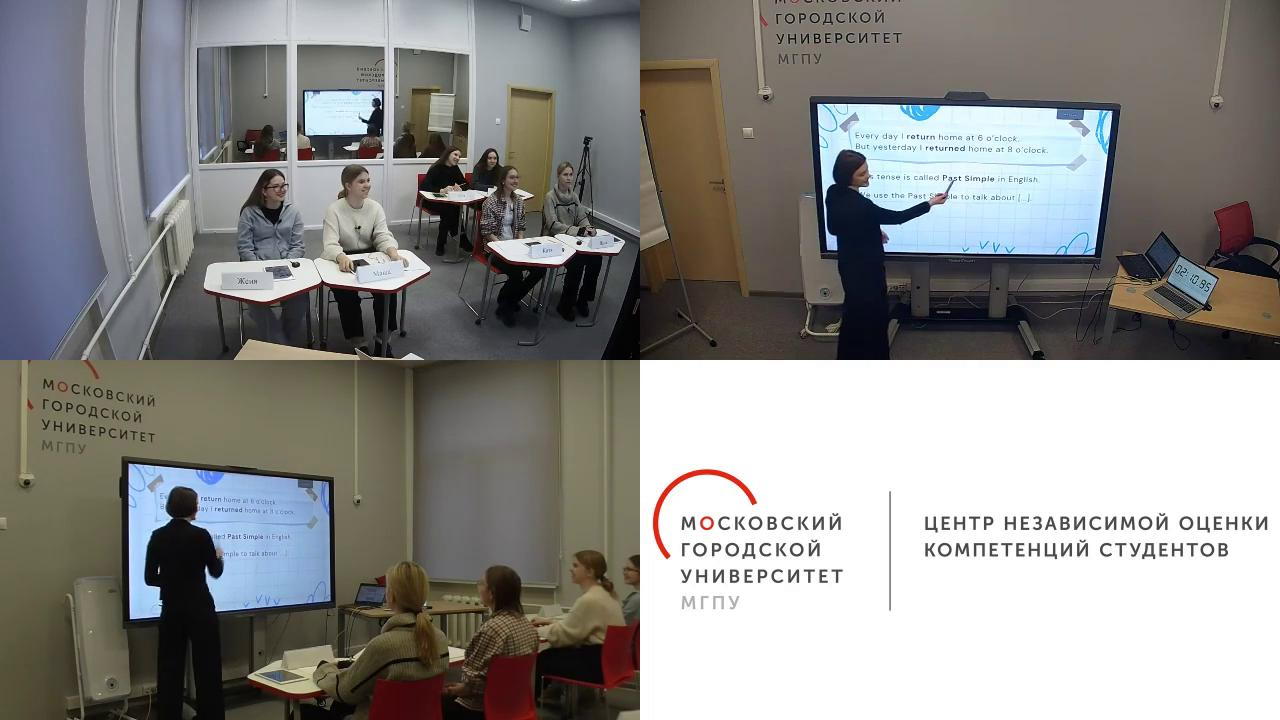


🎬 Видеофрагмент:



📝 Транскрибированный текст:
We are allğimizenib


In [6]:
# ==============================================================================
#  Шаг 5: Просмотр промежуточных результатов
# ==============================================================================
def review_sample(index):
    """Функция для отображения одного элемента датасета."""
    if index >= len(metadata):
        print(f"Индекс {index} вне диапазона. Доступно {len(metadata)} элементов.")
        return

    sample = metadata[index]

    print("="*50)
    print(f"Просмотр элемента: {sample['id']}")
    print(f"Паттерн: {sample['pattern_type']}")
    print(f"Время: {sample['start_time']}s - {sample['end_time']}s")
    print(f"Описание: {sample['pattern_description']}")
    print("="*50)

    # Отображение кадра
    print("\n🖼️ Ключевой кадр:")
    image_full_path = os.path.join(DATASET_OUTPUT_DIR, sample['image_path'])
    if os.path.exists(image_full_path):
        display(Image(filename=image_full_path, width=400))
    else:
        print("Кадр не найден.")

    # Воспроизведение видео
    print("\n🎬 Видеофрагмент:")
    video_full_path = os.path.join(DATASET_OUTPUT_DIR, sample['video_path'])
    if os.path.exists(video_full_path):
        display(Video(video_full_path, embed=True, width=400))
    else:
        print("Видео не найдено.")

    # Отображение текста
    print("\n📝 Транскрибированный текст:")
    text_full_path = os.path.join(DATASET_OUTPUT_DIR, sample['text_path'])
    if os.path.exists(text_full_path):
        with open(text_full_path, 'r', encoding='utf-8') as f:
            print(f.read())
    else:
        print("Текст не найден.")

# Просмотрим случайный элемент (например, 2-й по счету)
print("\n🔬 Просмотр одного из сгенерированных примеров...")
review_sample(2)

In [ ]:
# ==============================================================================
#  Шаг 6: Сохранение и загрузка в Hugging Face
# ==============================================================================
# Сохраняем метаданные в формате jsonl
metadata_path = os.path.join(DATASET_OUTPUT_DIR, 'metadata.jsonl')
with open(metadata_path, 'w', encoding='utf-8') as f:
    for item in metadata:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

print(f"\n💾 Финальный датасет сохранен в директории: {DATASET_OUTPUT_DIR}")
print(f"📄 Метаданные сохранены в файле: {metadata_path}")
print(f"\nСтруктура датасета готова к загрузке в Hugging Face.")

# --- Инструкция по загрузке в Hugging Face ---
print("\n---")
print("☁️ Чтобы загрузить датасет в Hugging Face, выполните следующие ячейки:")

# Ячейка 1: Аутентификация
# notebook_login()

# Ячейка 2: Создание репозитория и загрузка
#
# HF_USERNAME = "your-username" # <-- ВАШ ЛОГИН НА HUGGING FACE
# DATASET_NAME = "ppi-pedagogical-patterns-dataset" # <-- НАЗВАНИЕ ВАШЕГО ДАТАСЕТА
#
# # Создаем репозиторий датасета на Hugging Face
# repo_url = create_repo(
#     repo_id=f"{HF_USERNAME}/{DATASET_NAME}",
#     repo_type="dataset",
#     exist_ok=True
# )
# print(f"Репозиторий создан/найден: {repo_url}")
#
# # Загружаем всю папку с датасетом
# print("⏳ Начинается загрузка... Это может занять много времени в зависимости от размера.")
# upload_folder(
#     folder_path=DATASET_OUTPUT_DIR,
#     repo_id=f"{HF_USERNAME}/{DATASET_NAME}",
#     repo_type="dataset"
# )
# print("✅ Загрузка завершена!")